import the modules and get dataset

In [138]:
import pandas as pd
import numpy as np
import warnings
import cv2
import data
import model
from PIL import Image
import dlib
warnings.filterwarnings("ignore")

data.get_files_CNN()
df = pd.read_csv("dataset.csv")
print(df.head())

                                              pixels  emotion
0  6 5 3 3 5 9 11 11 13 17 22 24 31 32 38 37 34 3...    happy
1  42 19 2 2 9 10 4 2 6 8 10 15 9 12 14 15 19 35 ...  sadness
2  10 0 0 1 0 1 3 4 6 10 21 56 93 117 161 182 195...  sadness
3  172 186 186 145 103 120 202 242 195 180 150 82...  sadness
4  216 218 214 216 215 223 193 67 52 58 65 60 57 ...  sadness


convert the dataset to data we can actually use

In [139]:
image_size = (48, 48)
pixels = df['pixels'].tolist()  # Converting the relevant column element into a list for each row
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]  # Splitting the string by space character as a list
    face = np.asarray(face).reshape(width, height)  # converting the list to numpy array in size of 48*48
    face = cv2.resize(face.astype('uint8'), image_size)  # resize the image to have 48 cols (width) and 48 rows (height)
    faces.append(face.astype('float32'))  # makes the list of each images of 48*48 and their pixels in numpyarray form

faces = np.asarray(faces)  # converting the list into numpy array
faces = np.expand_dims(faces, -1)  # Expand the shape of an array -1=last dimension => means color space
emotions = pd.get_dummies(df['emotion']).to_numpy()  # doing the one hot encoding type on emotions

print(faces[0])

[[[  6.]
  [  5.]
  [  3.]
  ...
  [ 20.]
  [ 34.]
  [ 48.]]

 [[  2.]
  [  1.]
  [  3.]
  ...
  [ 25.]
  [ 22.]
  [ 37.]]

 [[  3.]
  [  3.]
  [  6.]
  ...
  [ 34.]
  [ 21.]
  [ 28.]]

 ...

 [[138.]
  [135.]
  [146.]
  ...
  [139.]
  [140.]
  [142.]]

 [[137.]
  [138.]
  [122.]
  ...
  [138.]
  [149.]
  [144.]]

 [[138.]
  [115.]
  [ 57.]
  ...
  [144.]
  [138.]
  [143.]]]


check how the faces look like:

In [140]:
print(faces.shape)
print(faces[0].ndim)
print(type(faces))

(480, 48, 48, 1)
3
<class 'numpy.ndarray'>


the emotions after preprocessing:

In [141]:
print(emotions[0]) #Emotion after preprocessing
print(emotions.shape)
print(emotions.ndim)
print(type(emotions))

[0 0 1 0]
(480, 4)
2
<class 'numpy.ndarray'>


time to scale the pixels and check if the min and max are -1.0 and 1.0

In [142]:
x = faces.astype('float32')
x = x / 255.0 #Dividing the pixels by 255 for normalization  => range(0,1)

# Scaling the pixels value in range(-1,1)
x = x - 0.5
x = x * 2.0
print(x[0])
print(x.min(),x.max())

[[[-0.9529412 ]
  [-0.9607843 ]
  [-0.9764706 ]
  ...
  [-0.84313726]
  [-0.73333335]
  [-0.62352943]]

 [[-0.9843137 ]
  [-0.99215686]
  [-0.9764706 ]
  ...
  [-0.8039216 ]
  [-0.827451  ]
  [-0.70980394]]

 [[-0.9764706 ]
  [-0.9764706 ]
  [-0.9529412 ]
  ...
  [-0.73333335]
  [-0.8352941 ]
  [-0.78039217]]

 ...

 [[ 0.082353  ]
  [ 0.05882359]
  [ 0.14509809]
  ...
  [ 0.09019613]
  [ 0.09803927]
  [ 0.11372554]]

 [[ 0.07450986]
  [ 0.082353  ]
  [-0.04313725]
  ...
  [ 0.082353  ]
  [ 0.1686275 ]
  [ 0.12941182]]

 [[ 0.082353  ]
  [-0.09803921]
  [-0.5529412 ]
  ...
  [ 0.12941182]
  [ 0.082353  ]
  [ 0.12156868]]]
-1.0 1.0


split data into train and test data

In [143]:
num_samples, num_classes = emotions.shape

num_samples = len(x)
num_train_samples = int((1 - 0.2)*num_samples)

# Traning data
train_x = x[:num_train_samples]
train_y = emotions[:num_train_samples]

# Validation data
val_x = x[num_train_samples:]
val_y = emotions[num_train_samples:]

train_data = (train_x, train_y)
val_data = (val_x, val_y)

print('Training Pixels',train_x.shape)  # ==> 4 dims -  no of images , width , height , color
print('Training labels',train_y.shape)

print('Validation Pixels',val_x.shape)
print('Validation labels',val_y.shape)

Training Pixels (384, 48, 48, 1)
Training labels (384, 4)
Validation Pixels (96, 48, 48, 1)
Validation labels (96, 4)


import keras for the model training and layers

In [144]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

create the model with it's layers:

In [145]:
input_shape=(48, 48, 1)
num_classes = 4

model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', input_shape=input_shape))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_48 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 10, 10, 32)        25632     
_________________________________________________________________
activation_49 (Activation)   (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)             

the parameters:

import data generator

In [146]:
from keras.preprocessing.image import ImageDataGenerator


compile the model:

In [147]:
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
batch_size = 32
opt = RMSprop(lr=0.0005, decay=1e-6)

model_1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_1 = model_1.fit_generator(data_generator.flow(train_x, train_y,
                                            batch_size),
                        epochs=100, verbose=1,validation_data =val_data)

Epoch 1/100
12/12 [==============================] - 0s 21ms/step - loss: 1.2665 - accuracy: 0.4271 - val_loss: 1.1900 - val_accuracy: 0.4583
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 1.2148 - accuracy: 0.4635 - val_loss: 1.1184 - val_accuracy: 0.5417
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 1.1331 - accuracy: 0.5026 - val_loss: 0.9763 - val_accuracy: 0.5938
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 1.0079 - accuracy: 0.6042 - val_loss: 0.7816 - val_accuracy: 0.6979
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 0.8605 - accuracy: 0.6250 - val_loss: 0.6345 - val_accuracy: 0.7083
Epoch 6/100
12/12 [==============================] - 0s 13ms/step - loss: 0.8318 - accuracy: 0.6641 - val_loss: 0.5815 - val_accuracy: 0.7292
Epoch 7/100
12/12 [==============================] - 0s 12ms/step - loss: 0.7519 - accuracy: 0.7031 - val_loss: 0.5681 - val_accuracy: 0.7812
Epoch 

12/12 [==============================] - 0s 13ms/step - loss: 0.2455 - accuracy: 0.8854 - val_loss: 0.1181 - val_accuracy: 0.9688
Epoch 59/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2924 - accuracy: 0.8880 - val_loss: 0.1994 - val_accuracy: 0.8958
Epoch 60/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2054 - accuracy: 0.9141 - val_loss: 0.1151 - val_accuracy: 0.9688
Epoch 61/100
12/12 [==============================] - 0s 12ms/step - loss: 0.2089 - accuracy: 0.9141 - val_loss: 0.1496 - val_accuracy: 0.9271
Epoch 62/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2135 - accuracy: 0.9010 - val_loss: 0.1590 - val_accuracy: 0.9167
Epoch 63/100
12/12 [==============================] - 0s 13ms/step - loss: 0.2234 - accuracy: 0.9193 - val_loss: 0.1373 - val_accuracy: 0.9167
Epoch 64/100
12/12 [==============================] - 0s 14ms/step - loss: 0.1778 - accuracy: 0.9297 - val_loss: 0.1310 - val_accuracy: 0.9479
Epoch 65/100

Plot

3/3 [==============================] - 0s 2ms/step - loss: 0.0563 - accuracy: 1.0000


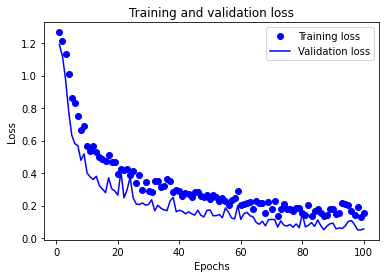

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
score = model_1.evaluate(val_x, val_y, verbose=1)
history_dict=hist_model_1.history
history_dict.keys()

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

evaluate model: